# Predicting the Importance of a Publication

In [20]:
from IPython.display import Image

### The product is a model which can prioritize a reading list from recently published literature, the importance of recently published articles is predicted using past articles



### Fig. 1

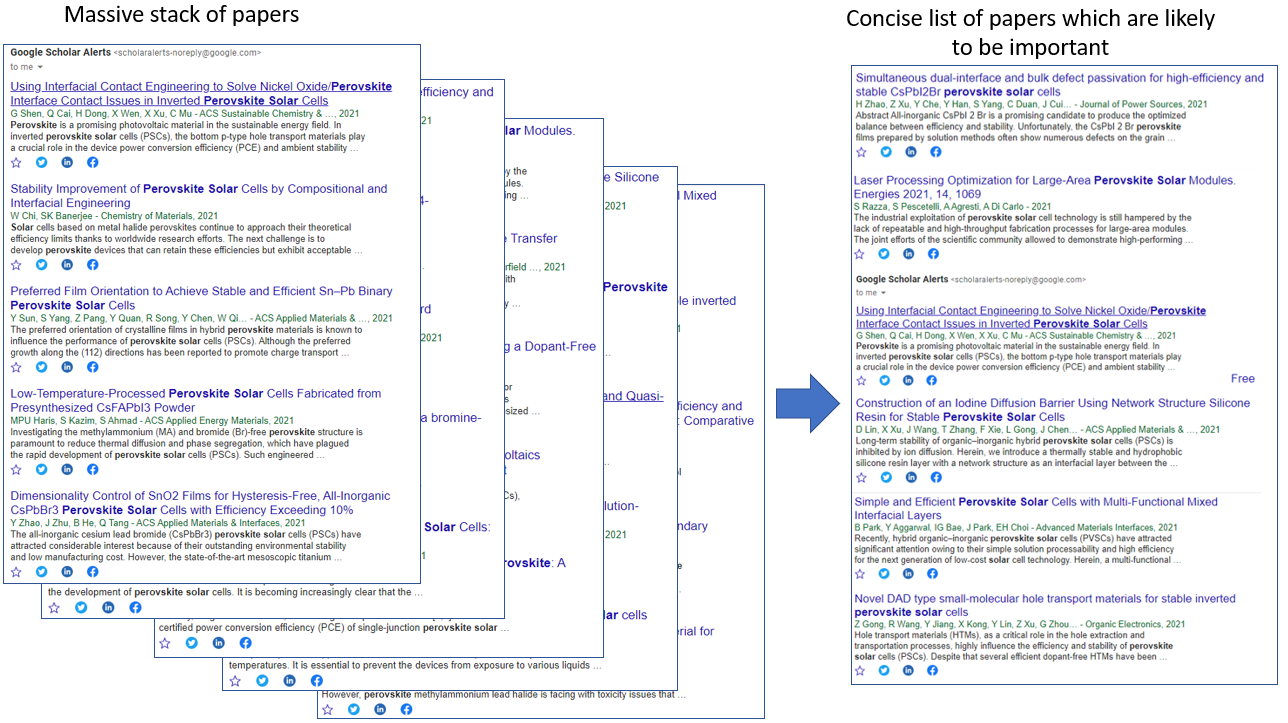

In [12]:
Image(filename='organizing gs image 2.PNG') 

### Motivational Anecdote
#### If 10,000 papers on a topic are published per year (the case for my field during my PhD), then you'd need to skim the metadata and abstracts of ~28 papers per day, every day, to decide what to read. 
#### This work is partially motivated by a near miss I had while working in a previous role, where my daily reading caught a paper which changed the research direction of the company. If it had been a busier week, or I was tired / distracted, this update could have been missed. 
#### In hindsight, this paper should have been obvious given the authors, journal, and title, but I was the only one at the company who (mostly by luck) caught it. As the pace of innovation accelerates, delays catching crucial updates and incoproating them into an organizations plan cost time and money

### Importance can be measured by number of citations

### Fig. 2

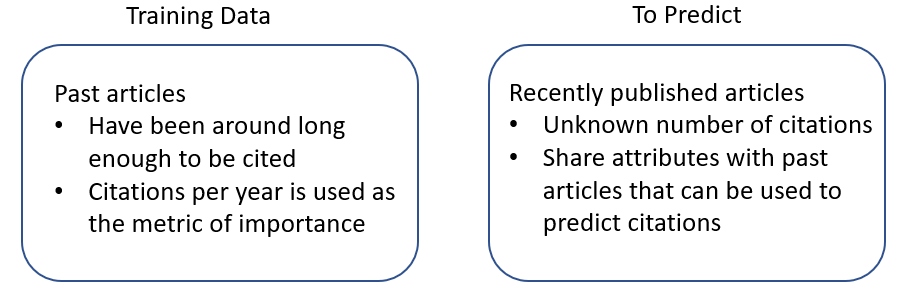

In [11]:
Image(filename='Training and to predict.PNG') 

### Fig. 3: Screen shots from an API to the model
API built with Flask. The code for this is in the "API" folder, but I haven't hosted it publically yet

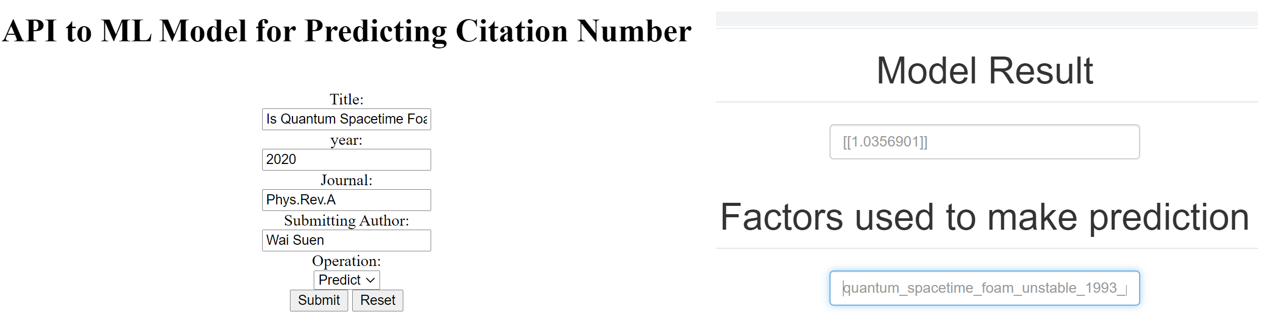

In [10]:
Image(filename='API image.PNG')

### The product will allow incoming literature to be sorted by order of importance. The data used to train the model here is from academic papers, but this approach could also be useful for patent literature

## Data Collection
Extracted papers which were published in academic journals from a kaggle dataset (2.7 GB), then scrapped the citation number from google scholar. ~50 GB of data was parsed in the scrapping process. The resulting data set which was fed into the macine learning pipeline was 400 MB. This was distiled down to inputs (X: sparse matrix, and y: array) of about 13 MB.

## Data Processing

### Fig. 4 Data processing pipeline

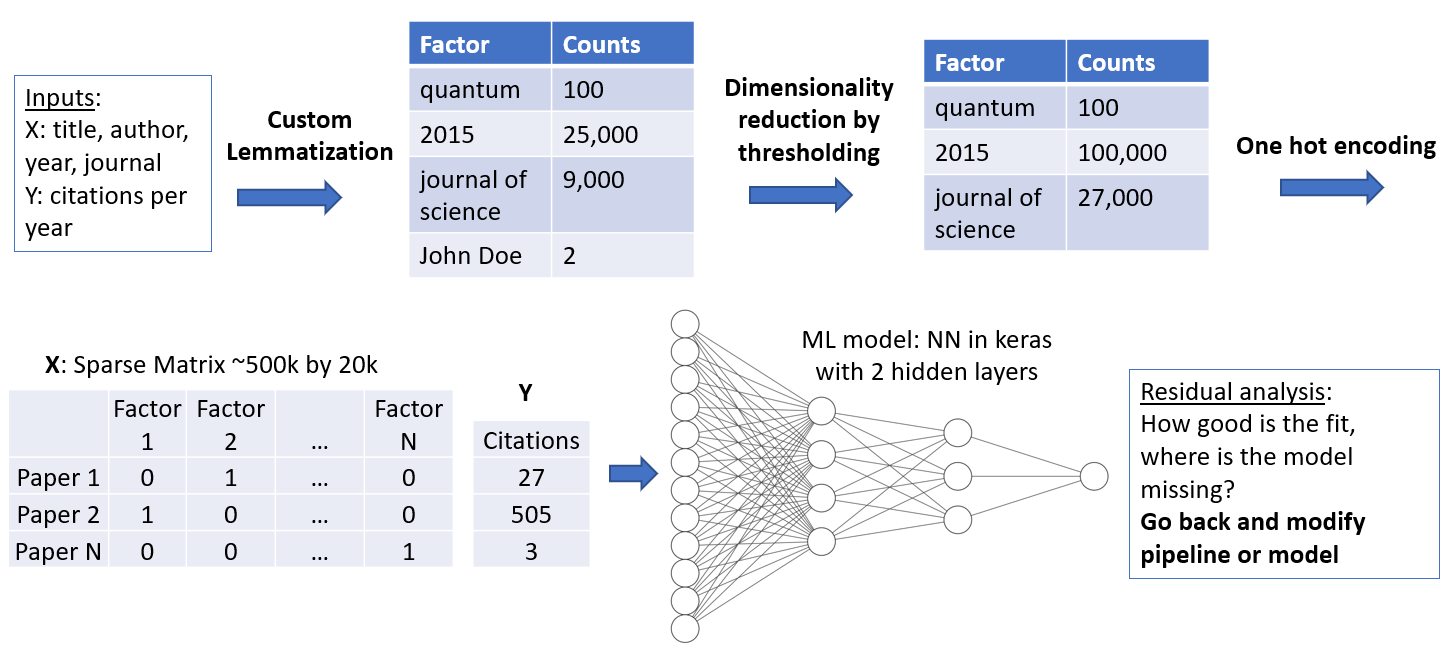

In [44]:
Image(filename='Pipeline schematic.PNG') 

## Preliminary Fit
#### * years 1990-2018 used as training, 2019-2020 used as test
#### * Validated with test set to prevent overfitting
#### * used mean absolute error due to shape of y data, current MAE is 4.1 citations per year, mean citations per year is 3

### Fig. 5: Histogram of how many papers have how many citations

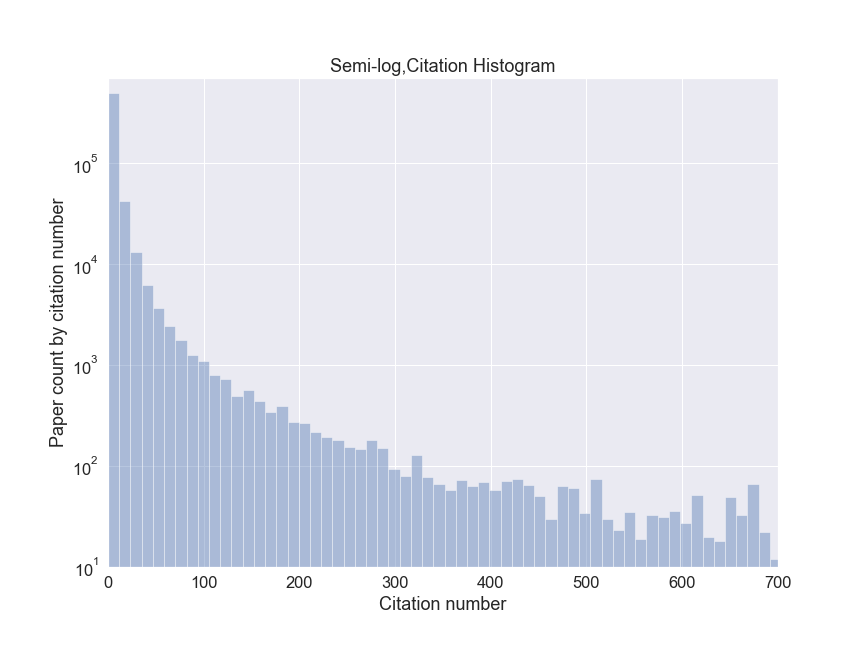

In [21]:
Image(filename='citation histogram.PNG') 

#### An analysis of the residuals for the test set is shown below in Fig. 6. The residuals for the model are compared to the where the citations per year for each paper are guessed by choosing a random value from the array of y_test

#### model: residuals = (y_model - y_actual)
#### randomized residuals = (choose random from all y_actual - y_actual)

### Fig 6: Residual Analysis

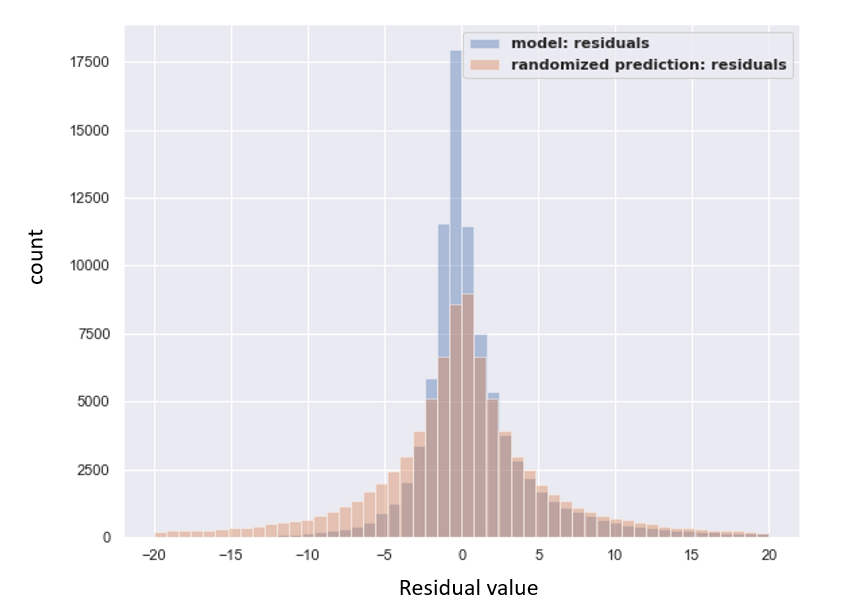

In [52]:
Image(filename='residuals fixed labels.PNG') 

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Table of Contents for Work Done So Far

### * [Preliminary Data Analysis](#prelimDataAnalysis)

### * [Setting Up Inputs to an ML Model](#setUpInput4Model)

### * [Preliminary Fit Using Keras](#prelimFitKeras)

### * [Residual Analysis](#ResAnalysis)

### * [Future Work](#futureWork)




# Preliminary Data Analysis <a class="anchor" id="prelimDataAnalysis"></a>
The dataframe loaded is the result of combining the number of citations for each paper with the meta data for that paper. The scrapping process isn't addressed in this notebook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle as pckl
import os
from rawDataToBagOfWords_oneHotEncode import *  ### some functions located in other scripts are used
from modellingWith_xgboost import * ### some functions located in other scripts are used


In [2]:
#### loading a df from several .csv files
dfList = []
folder = 'dataframe for notebook/'

for file in os.listdir(folder):
    dfList.append(pd.read_csv(str(folder + file),dtype={'ids': object}))


df = pd.DataFrame()

for i,frame in enumerate(dfList):

    #print(frame.head())
    df= pd.concat([df,frame])

In [3]:
df = df.drop(labels = ['Unnamed: 0','Unnamed: 0.1'],axis = 1)

In [4]:
df.head()

,ids,title,journal reference,cited,year,submitting author,category
0,704.0135,A Single Trapped Ion as a Time-Dependent Harmo...,"Phys. Rev. A 76, 052105 (2007)",26,2007,Nicolas Menicucci,quant-ph
1,704.0137,"Topological defects, geometric phases, and the...",Optik-International Journal for Light and Elec...,1,2009,Suresh Tiwari dr,quant-ph
2,704.0138,Circular and non-circular nearly horizon-skimm...,"Phys.Rev.D76:044007,2007",18,2007,Enrico Barausse,gr-qc astro-ph
3,704.0139,The Blue Straggler Population of the Globular ...,"Astrophys.J.663:267-276,2007",79,2007,Barbara Lanzoni,astro-ph
4,704.014,Entanglement entropy of two-dimensional Anti-d...,"Phys.Lett.B653:434-438,2007",31,2007,Mariano Cadoni,hep-th


In [5]:
df.describe()

,cited,year
count,578667.000000,578667.000000
mean,343.110922,2010.382572
std,2102.080560,6.859902
min,1.000000,1990.000000
25%,8.000000,2005.000000
50%,23.000000,2011.000000
75%,62.000000,2016.000000
max,126810.000000,2020.000000


In [8]:
df['cited'] = df['cited']/(2021 - df['year'])

Plotting a histogram of citation number per paper. This what a future model will try to predict

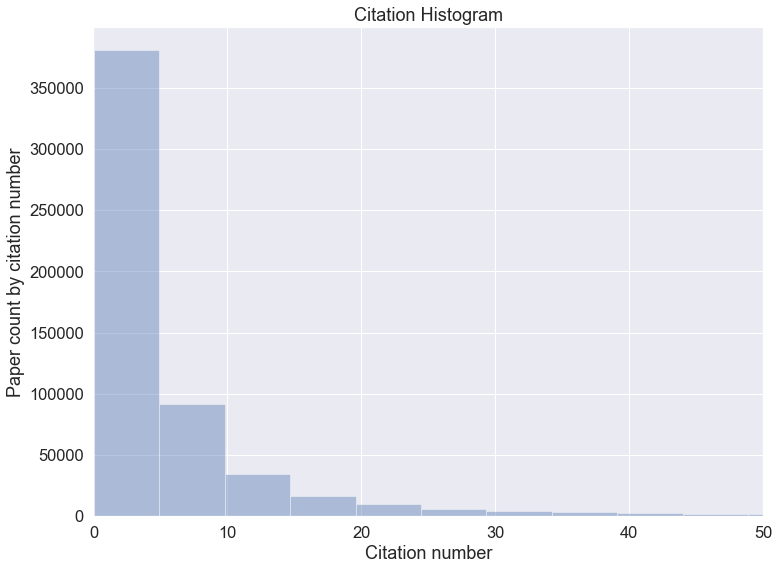

In [13]:
size = (12, 9)
citedDist = sns.distplot(x = df['cited'],bins = 12000, kde = False) #######
citedDist.set(xlim = (0,50))
citedDist.set_title(label = 'Citation Histogram')        
citedDist.set(ylabel='Paper count by citation number')
citedDist.set(xlabel='Citation number')
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)

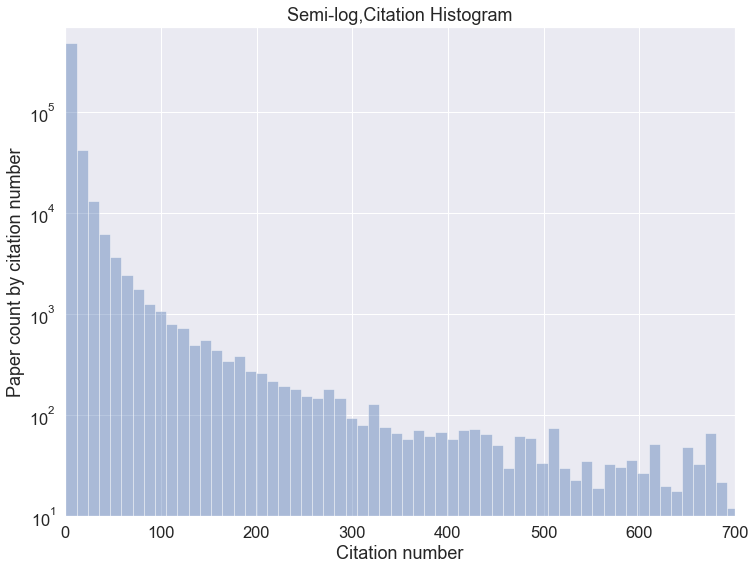

In [18]:
citedDist = sns.distplot(x = df['cited'],bins = 5000, kde = False)
citedDist.set(xlim = (0,700))
citedDist.set_title(label = 'Semi-log,Citation Histogram')        
citedDist.set(ylabel='Paper count by citation number')
citedDist.set(xlabel='Citation number')
citedDist.set_yscale("log")
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)
citedDist.set(ylim = (10,700000))
citedDist.figure.savefig("citation histogram.png")

Since there a few number of papers have a large number of citations, the histogram should also be viewed on a log scale

Looking at when these papers where published, is a trend in the number of papers published per year (it also looks like more people went to grad school or academia during the recession around 2009)


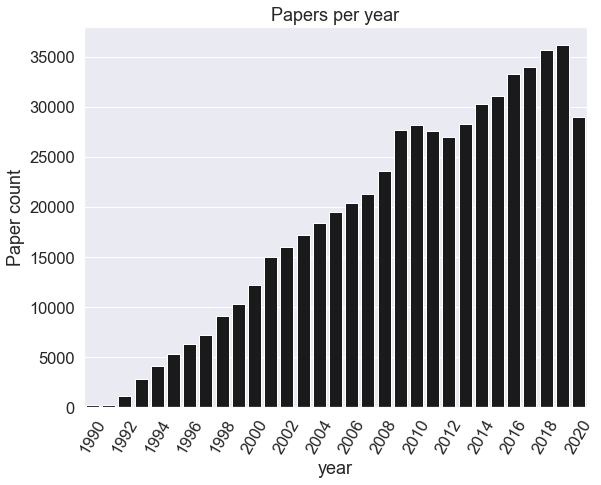

In [10]:
yearDist = sns.countplot(data = df, x = 'year',hue = None,color = 'k')
#yearDist.set(xlim = (0,1000))
plt.xticks(rotation=60)

xticks=yearDist.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
yearDist.set_title(label = 'Papers per year')        
yearDist.set(ylabel='Paper count')
yearDist.set(xlabel='year')

sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)
#change_width(yearDist, .5)

Since there's an increase in academic publishing (or at least in the corners of academia who use the Cornell archives) it would make sense that papers published in later years get more citations per year (total citations/years since publication). Note that the decrease in publications in 2020 is likely due to the data set being not updated to include everything in that year.

In [15]:
df['citedPerYear'] =df['cited']/(2021 - df['year'])

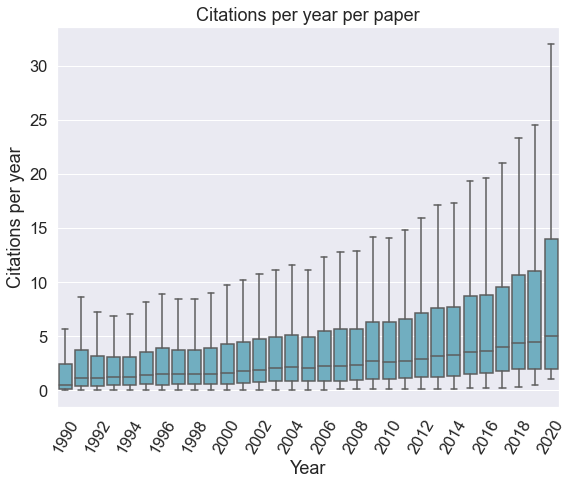

In [16]:
###### this is very slow to run
boxes = sns.boxplot(data = df,x = 'year',y = 'citedPerYear',showfliers=False,\
                    hue = None, color = 'c')

plt.xticks(rotation=60)

xticks=boxes.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)

boxes.set_title(label = 'Citations per year per paper')        
boxes.set(ylabel='Citations per year')
boxes.set(xlabel='Year')
plt.show()

It does seem that more recent papers are being cited more highly

# Setting Up Inputs to an ML Model <a class="anchor" id="setUpInput4Model"></a>

The initial attempt to fit an ML model involved converting the title, submitting author, year, and categories into a bag of words using one hot encoding. Spacy was used to extract the lemma from the title, and the other information was added afterwords. Most of the nonsense words and words which appeared infrequently were removed. An issue which has yet to be resolved is that spacy doesn't correctly lemmatize all the science words (antiferromagnetism vs antiferromagnetic)

This was used to construct a sparse matrix for input into an ML model. Some analysis on how many factors are used for each paper, and the number of connections (how many other papers a given paper shares it's words with) are shown below. Contructing and analyzing the bag of words and is done in rawDataToBagOfWords_oneHotEncode.py not this notebook


### A schematic of how the current pipeline is set up is shown below. 
The details of going from the raw html citations to Y won't be discussed here

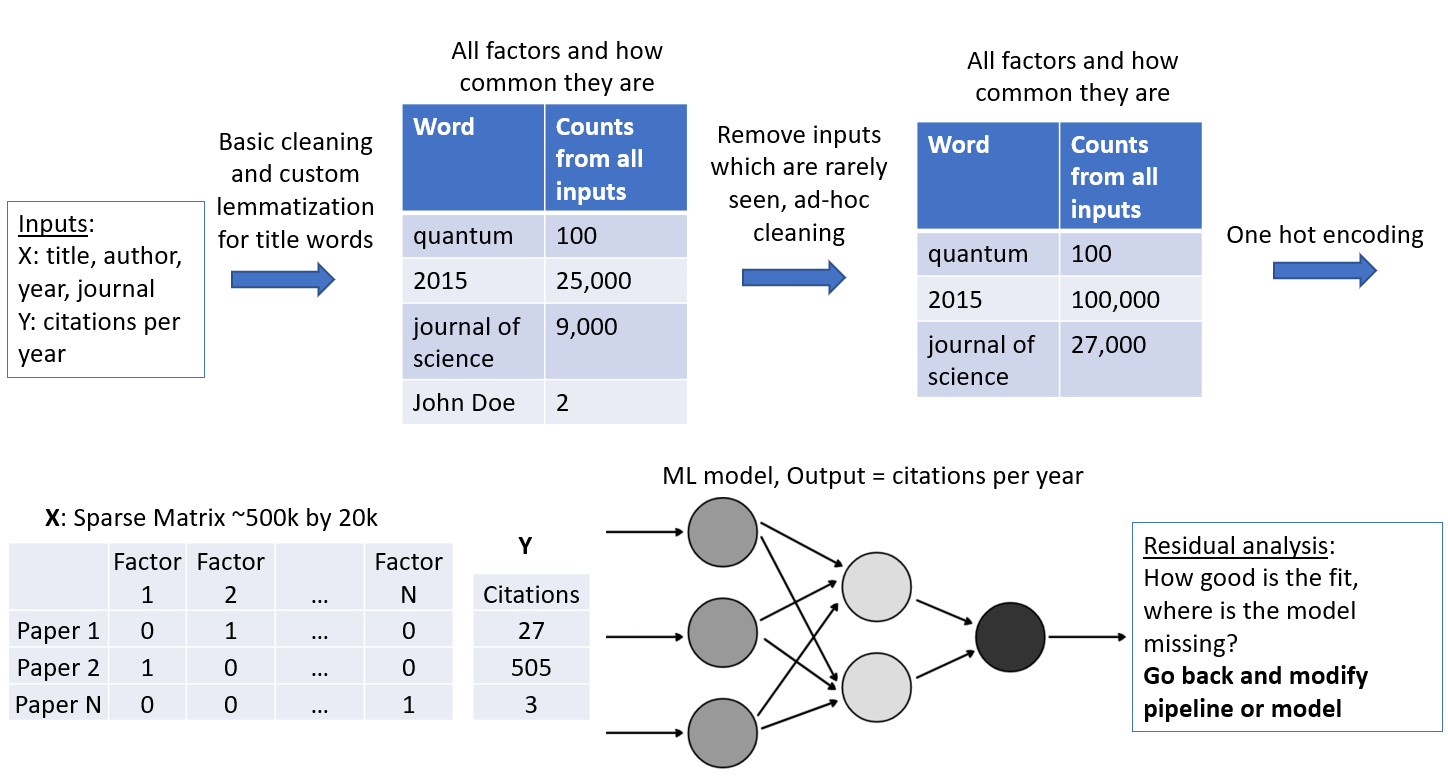

In [15]:
Image(filename='Pipeline schematic.PNG') 

In the development phase, ths pipeline is a bit circular. Even a basic residual analysis can inform as to what needs to be done to imporve the model


#### Loading data corresponding to the bag of words and performing analysis on the factors used
The full pipeline is fairly complex, and doesn't fit nicely into the walk through of the project given in this notebook. The full code to prepare the inputs to the ML model is in "rawDataToBagOfWords_oneHotEncode.py"

In [20]:
# preProcessingOut 2-8_write
X,y,inputs,names = loadInputData()
#dictMain = inputs[1]
dictBow = inputs[0]
# plotTokCnt(dictBow)
dictMainParts = inputs[1:5]

dictMain = {}

for dic in dictMainParts:
    dictMain.update(dic)

bowVecSpares.npz
dicBow.pckl
dictMain1.pckl
dictMain2.pckl
dictMain3.pckl
dictMain4.pckl
label.pckl
loaded inputs
changed to np arrays


In [21]:
len(dictMain) #### should be ~579k

578668

making df from the dictionary containing the paper id, how many times it was cited, and how many factors are used in the current model

In [22]:
# this cell is slow to run
dfBow = pd.DataFrame(dictMain)
dfBow = dfBow.transpose()
dfBow['ids'] = dfBow.index


In [23]:
colDict = {0:'cited',1:'all_factors',2:'num_factors_used'}
dfBow = dfBow.rename(columns = colDict)
dfBow.columns


Index(['cited', 'all_factors', 'num_factors_used', 'ids'], dtype='object')

In [24]:
dfBow['num_factors_used'] = dfBow['num_factors_used'].astype(int)

looking at the number of factors per paper to be used in the model. This is number of word words left in the bag of words after removing nonsense and words with only ~3 occurances. 

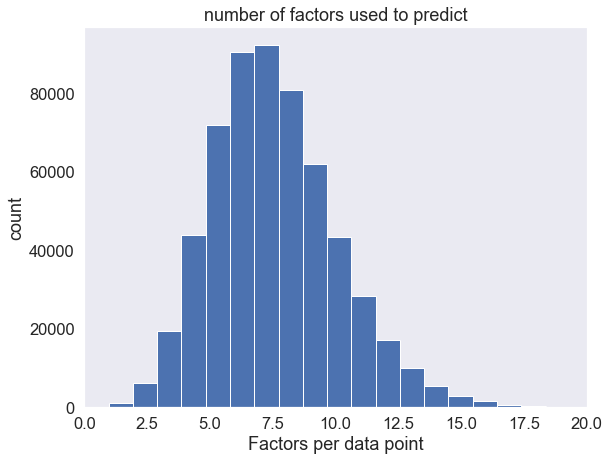

In [25]:
ax2 = dfBow['num_factors_used'].hist(bins = 30,grid = False)

ax2.set(xlim = (0,20))
ax2.set_title(label = 'number of factors used to predict')        
ax2.set(ylabel='count')
ax2.set(xlabel='Factors per data point')
plt.show()

skewed distribution showing that most papers have ~7 words (or factors) this isn't suprising given that the titles have similar length, and each paper will have at least a year and a category

#### Another way to look at the input data is by how many other papers a paper is connected to through the above factors. 
This was done by calcuating the number of unique connections in graph (the papers are nodes and two papers may share more than one factor, or have more than one edge/connection). For a sparse matrix of 500k by 18k, this was very slow and the code isn't shown here. The result is loaded from the file conVec4DataProcessed2-8.pckl


In [26]:
import pickle as pckl
import os
#path = os.getcwd() + '/' + 'preProcessingOut 2-8' +'/'
#file = path + 'conVec4DataProcessed2-8.pckl'
file = 'conVec4DataProcessed2-8.pckl'
with open(file,'rb') as f:
    conVec = pckl.load(f)

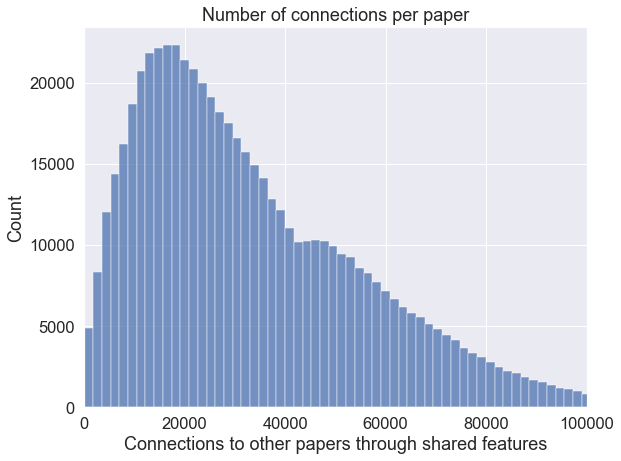

In [27]:
size = (9, 7)
citedDist = sns.histplot(x = conVec,bins = 100, kde = False) #######
citedDist.set(xlim = (0,100000))
citedDist.set_title(label = 'Number of connections per paper')        
citedDist.set(ylabel='Count')
citedDist.set(xlabel='Connections to other papers through shared features')
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)

Most of the papers have tens of thousands of connections, and there may a grouping which is more highly connected

# Preliminary Fit Using Keras <a class="anchor" id="prelimFitKeras"></a>

This attempt predict the citations resulted in most predicitions being the mean of the data set, meaning more factors, or more predictive factors, may be needed.

#### Sidenote: training and saving the model is very unweildy, this section is mainly for show

In [ ]:
from modellingWith_xgboost_or_tf_forJP import *

In [29]:
# loading the inputs (X -> sparse matrix, Y: np array, dictMain: dictionary containg the unique ID, citations per year,
# and factors used for each paper)

X, y, inputs, names = loadInputData2()
dictMain = inputs[1] ###### grabing the main dictionary from the list of loaded variables. This keeps track of each paper
citedList = getListCitedBy(dicMain) 

### shuffling all the input variables to ensure traintest split is random
dicMainKeys, X, y = shuffle(dictMain, X, y)

#X = X.tocsr(copy=True)

####### spliting up inputs
Xm_train, Xm_test, ym_train, ym_test, keys_train, keys_test, cited_train, \
    cited_test = manTTS(dictMainKeys, X, y, citedList) 

In [30]:
def trainKeras(Xm_train, ym_train) -> object:
    """ defining and training a keras model. Just using train test split for now, not k fold cross validation
    
    params: 
        Xm_train: scipy sparse matrix, the X training data
        ym_train: numpy array, the y training data
    """    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    import tensorflow as tf
    from math import ceil
    
    ###### defining a batch generator which converts the sparse X data into dense, then feeds it to keras along with y data
    def batch_generator(Xl, yl, batch_size): 
        number_of_batches = samplesPerEpoch/batchSize
        counter=0
        shuffle_index = np.arange(np.shape(yl)[0])
        np.random.shuffle(shuffle_index)
        Xl =  Xl[shuffle_index, :]
        yl =  yl[shuffle_index]
        while 1:
            index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
            X_batch = Xl[index_batch,:].todense()
            y_batch = yl[index_batch]
            counter += 1
            yield(np.array(X_batch),y_batch)
            if (counter < number_of_batches):
                np.random.shuffle(shuffle_index)
                counter=0
    
    
    model = Sequential()
    model.add(Dense(Xm_test.shape[1],activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(25,activation = 'relu'))
    model.add(Dropout(.3))
    model.add(Dense(10,activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(1))
    
    samplesPerEpoch=Xm_train.shape[0]
    batchSize = ceil(Xm_train.shape[0]/300)  ####### chooseing the batch size to be something which fits in memory
    
    # for log loss https://keras.io/api/losses/regression_losses/#mean_squared_logarithmic_error-function
    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    model.fit_generator(generator=batch_generator(Xm_train, ym_train, \
                    batch_size = batchSize), steps_per_epoch=300, epochs = 4)
    
    return model

In [ ]:
# actually training the model !!!!!!!!
model = trainKeras(Xm_train, ym_train)

In [ ]:
#saving model for later use
import os
cwd = os.getcwd()
model.save(cwd)

In [13]:
# defining function to get the predictions. Splitting up inputs into batches using a loop to avoid memory issues on converting
# sparse to dense

def predictKeras(model,Xm):
    
    preds = []
    incSize = 5000
    numBatch = math.ceil(Xm_test.shape[0]/incSize)
    for ind in range(numBatch):
        if (ind + 1) * incSize > Xm_test.shape[0]:
            indEnd = Xm_test.shape[0]
        else:
            indEnd = (ind + 1) * incSize
        
        X_batch = Xm_test[(ind * incSize): indEnd, :].todense()
            
        preds.append(model.predict(X_batch))
    
    return preds

In [33]:
# Getting predictions
predsOut = tempFlattenPreds(preds)

#### we will merge these predictions back into a dataframe(not shown here) and use them for residual  analysis in the next section

# Residual analysis <a class="anchor" id="ResAnalysis"></a>

Analyzing a set of residuals from the test set of an earlier run on the model. The predicted and actual citations per year have been placed into a dataframe containing only the test set.

In [ ]:
#### loading predictions and actual from the test set

In [69]:
df2 = pd.read_csv('resDF_3-3.csv')

C:\Users\bcyk5\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,2,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [70]:
import seaborn as sns



In [71]:
# defining a function for calculating the relative residuals
def getRelativeRes(x):
    """ want to normalize the residuals by the min of the predicted and actual
        This will show which predictions are off by a large amount. For example,
        if the actual was 20 and we predict 40 thats not too bad (off by 2x). but if the actual 
        was 20 and we predict 0.5 thats terrible (off by 40x)
    
        this metric (or similar) is a candiate for a custom loss function in future work
    """
    return (x.pred - x.actual)/min(x.pred,x.actual)

In [72]:
# calculating absolute and relative residuals
#df2['normRes'] = df2['res']/df2['actual']
df2['relativeRes'] = df2.apply(getRelativeRes, axis =1)

In [73]:
### defining a histogram platting function
def basicHist(df2,col,xLow,xHigh,bins):
    resDist = sns.distplot(x = df2[col],bins = bins, kde = False)
    #resDist.set(yscale="log")
    resDist.set(xlim = (xLow,xHigh))
    resDist.set_title(label = 'residual histogram')        
    resDist.set(ylabel='count')
    resDist.set(xlabel='residual')

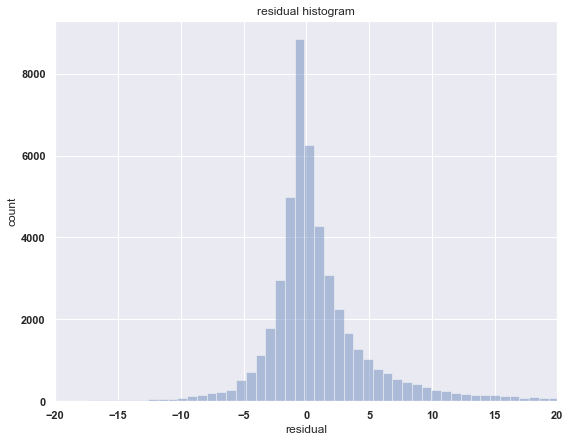

In [74]:
# plotting the residuals
basicHist(df2,'res',-20,20,10000)

The residuals aren't normally distributed, although this can be expected do to the distribution we are trying to predict

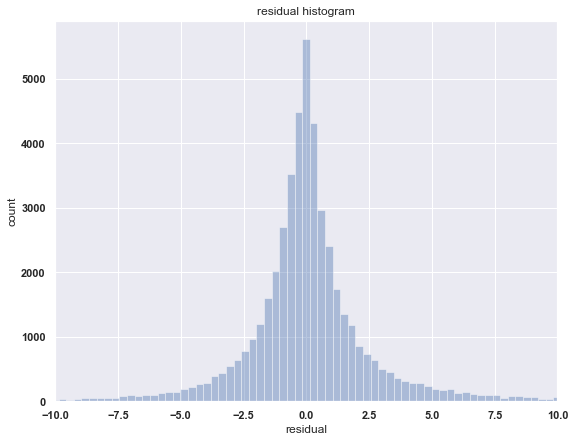

In [75]:
# plotting the relative residuals, see above function for how these are calculated
basicHist(df2,'relativeRes',-10,10,5000)

The relative residuals are more useful for the purposes of this project, I just need to get within the ballpark so I can tell which papers are going to be highly impactful. Later on in the project, I'll define a metric for how many citations marks a paper as "impactful" and worth taking a look at

The model is within ~2.5 times the actual value for most of the data. However, there are long tails on the distribution are worth investigating. The next stage of residual analysis is to take a closer look at the these tails see where the model missed by such a large amount. 

#### The model is better at predicting the citation number than if we had just guessed a number of citations for each paper by randomly selecting from a list of know citation values. But it's not that much better. The model is far from useful and much more work is needed.

# Future work <a class="anchor" id="futureWork"></a>

The residual histogram shown above implies there is a lot of work to do before the can be useful. Future work will be continued in several directions outlined below.

1)   Get more data. The initial dataset is limited by number (~500k really isn't that great), and by how cleaned up the data can get with reasonable effort. In particular, the journal data contains lots of synomyms for a given journal which need to be resolved manually. Have started on a new scrapper to get this data.

2)   Add more advanced residual analysis methods to the pipeline which relfect the actual goal of the project. For example, what I really care about is how many high impact papers I'm missing, and how many low impact papers I'm falesly flagging

3)   Use a custom loss function which better reflects the information contained in the difference between actual and predicted citation values

4)   Add hyperparameter tuning to the pipleline and experiment with different models

5)   Package the pipeline in a way that it can be easily resused. The produect is a ML package which could be repurposed for different sets of papers, patents, or any other senario where the importance of a thing containing a small amount of text and meta data is desired
6)   Rework the train test splits so that the test data is the papers from the most recent year. This is crucial as it reflects the real world application.